## Neural Style Transfer

- Neural-Style, or Neural-Transfer, allows you to take an image and reproduce it with a new artistic style.

- The algorithm takes three images, an input image, a content-image, and a style-image, and changes the input to resemble the content of the content-image and the artistic style of the style-image.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

from torchvision.transforms import v2
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
torch.set_default_device(device)

device=device(type='cpu')


### load the images

In [3]:
# desired size of the output image
im_size = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = v2.Compose(
    [v2.Resize((im_size,im_size)), v2.PILToTensor(), v2.ToDtype(torch.float32, scale=True)]  # scale imported image
)  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("../assets/picasso.jpg")
content_img = image_loader("../assets/eiffel-tower.jpeg")

print(f"{style_img.size()=}; {content_img.size()=}")
assert (
    style_img.size() == content_img.size()
), "we need to import style and content images of the same size"

style_img.size()=torch.Size([1, 3, 128, 128]); content_img.size()=torch.Size([1, 3, 128, 128])


In [4]:
style_img.shape, content_img.shape

(torch.Size([1, 3, 128, 128]), torch.Size([1, 3, 128, 128]))

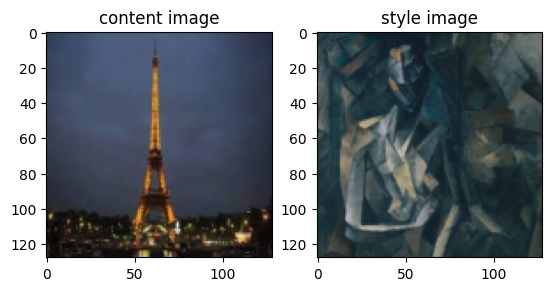

In [5]:
## Visualize image

_, ax = plt.subplots(ncols=2)
ax[0].imshow(content_img.squeeze().permute(1, 2, 0))
ax[0].title.set_text("content image")

ax[1].imshow(style_img.squeeze().permute(1, 2, 0))
ax[1].title.set_text("style image")

plt.show()

## `Loss-function`

### `Content loss function`

In [6]:
class ContentLoss(nn.Module):
    def __init__(
        self,
        target,
    ):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style loss:

#### Gram matrix 🤔

In [7]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [8]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

---

## Import the model

- Now we need to import a pre-trained neural network. We will use a 19 layer VGG network like the one used in the paper.

- PyTorch’s implementation of VGG is a module divided into two child Sequential modules:
  -  features (containing convolution and pooling layers),
  -  and classifier (containing fully connected layers).

-  We will use the features module because we need the output of the individual convolution layers to measure content and style loss.
-  Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using `.eval()`.

In [9]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [10]:
#  VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
# We will use them to normalize the image before sending it into the network.

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])


# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [11]:
# desired depth layers to compute style/content losses :
content_layers_default = ["conv_4"]
style_layers_default = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]


def get_style_model_and_losses(
    cnn,
    normalization_mean,
    normalization_std,
    style_img,
    content_img,
    content_layers=content_layers_default,
    style_layers=style_layers_default,
):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = "conv_{}".format(i)
        elif isinstance(layer, nn.ReLU):
            name = "relu_{}".format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = "pool_{}".format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = "bn_{}".format(i)
        else:
            raise RuntimeError(
                "Unrecognized layer: {}".format(layer.__class__.__name__)
            )

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[: (i + 1)]

    return model, style_losses, content_losses

Text(0.5, 1.0, 'Input Image')

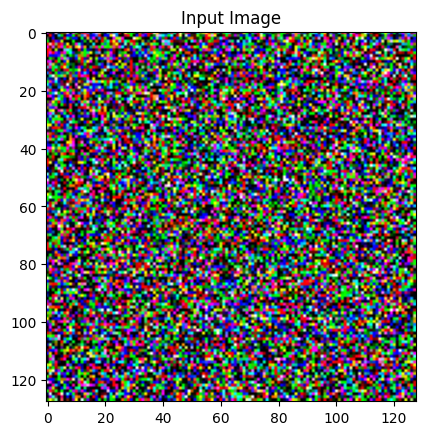

In [12]:
# input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
input_img = torch.randn(content_img.shape).clamp_(0,1)

# add the original input image to the figure:
plt.imshow(input_img.squeeze().permute(1,2,0))
plt.title("Input Image")

In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [14]:
def run_style_transfer(
    cnn,
    normalization_mean,
    normalization_std,
    content_img,
    style_img,
    input_img,
    num_steps=300,
    style_weight=1000000,
    content_weight=1,
):
    """Run the style transfer."""
    print("Building the style transfer model..")
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img
    )

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print("Optimizing..")
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print(
                    "Style Loss : {:4f} Content Loss: {:4f}".format(
                        style_score.item(), content_score.item()
                    )
                )
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 138.142258 Content Loss: 25.339596

run [100]:
Style Loss : 49.008488 Content Loss: 23.027382

run [150]:
Style Loss : 19.369389 Content Loss: 20.034351

run [200]:
Style Loss : 8.169831 Content Loss: 17.883282

run [250]:
Style Loss : 4.799014 Content Loss: 15.865858

run [300]:
Style Loss : 3.723694 Content Loss: 14.458961



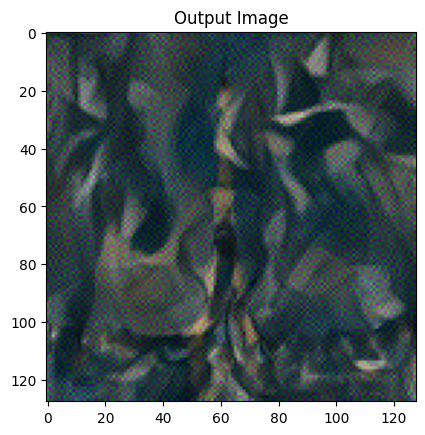

In [15]:
output = run_style_transfer(
    cnn,
    cnn_normalization_mean,
    cnn_normalization_std,
    content_img,
    style_img,
    input_img,
)

plt.imshow(output.detach().squeeze().permute(1,2,0))
plt.title("Output Image")

# sphinx_gallery_thumbnail_number = 4
plt.show()

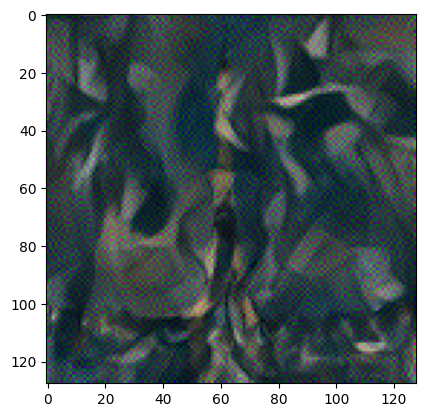

In [16]:
my_gen_img = output.squeeze().permute(1, 2, 0).detach()
my_gen_img.requires_grad = False
plt.imshow(my_gen_img)
plt.show()